In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
 # import一些會用到的函式庫
import pandas as pd
import numpy as np

import tensorflow as tf
import transformers #huggingface transformers library

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
# 使用Google Drive的路徑讀入我的資料集
df = pd.read_json('/content/drive/My Drive/AI-Final-Project/News_Category_Dataset.json', lines = True)
df.head()



,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [4]:
# 使用google colab TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.101.135.186:8470
REPLICAS:  8


In [5]:
# 把類別THE WORLDPOST 重新命名為WORLDPOST
df.category = df.category.map(lambda x : "WORLDPOST" if x == "THE WORLDPOST" else x)

In [6]:
# 看看此資料集有幾種不同的類別
print(f"此資料集有 {df.category.nunique()} 個類別")

此資料集有 41 個類別


In [7]:
# 增加一個欄位categoryEncoded放category encode 後的結果
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['category'])

In [8]:
# 看看現在的資料集
df.head()

,link,headline,category,short_description,authors,date,categoryEncoded
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,34
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,34
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,5
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,22
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,34


In [9]:
# 使用的模型為bert-large-uncased，因此要把我的headline和description全部改為小寫
df['headline'] = df['headline'].apply(lambda headline : str(headline).lower())
df['short_description'] = df['short_description'].apply(lambda des : str(des).lower())
# 看看現在的資料集
df.head()

,link,headline,category,short_description,authors,date,categoryEncoded
0,https://www.huffpost.com/entry/covid-boosters-...,over 4 million americans roll up sleeves for o...,U.S. NEWS,health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,34
1,https://www.huffpost.com/entry/american-airlin...,"american airlines flyer charged, banned for li...",U.S. NEWS,he was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,34
2,https://www.huffpost.com/entry/funniest-tweets...,23 of the funniest tweets about cats and dogs ...,COMEDY,"""until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,5
3,https://www.huffpost.com/entry/funniest-parent...,the funniest tweets from parents this week (se...,PARENTING,"""accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,22
4,https://www.huffpost.com/entry/amy-cooper-lose...,woman who called cops on black bird-watcher lo...,U.S. NEWS,amy cooper accused investment firm franklin te...,Nina Golgowski,2022-09-22,34


In [10]:
# 新增一個欄位 分別是headline, short_description 的長度
df['descr_len'] = df['short_description'].apply(lambda x : len(str(x).split()))
df['headline_len'] = df['headline'].apply(lambda x : len(str(x).split()))
# 看看現在的資料集
df.head()

,link,headline,category,short_description,authors,date,categoryEncoded,descr_len,headline_len
0,https://www.huffpost.com/entry/covid-boosters-...,over 4 million americans roll up sleeves for o...,U.S. NEWS,health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,34,29,11
1,https://www.huffpost.com/entry/american-airlin...,"american airlines flyer charged, banned for li...",U.S. NEWS,he was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,34,28,13
2,https://www.huffpost.com/entry/funniest-tweets...,23 of the funniest tweets about cats and dogs ...,COMEDY,"""until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,5,12,13
3,https://www.huffpost.com/entry/funniest-parent...,the funniest tweets from parents this week (se...,PARENTING,"""accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,22,25,9
4,https://www.huffpost.com/entry/amy-cooper-lose...,woman who called cops on black bird-watcher lo...,U.S. NEWS,amy cooper accused investment firm franklin te...,Nina Golgowski,2022-09-22,34,25,11


In [11]:
# 看看關於categoryEncoded, descr_len, headline_len的資訊
df.describe()

,categoryEncoded,descr_len,headline_len
count,209527.000000,209527.000000,209527.000000
mean,22.294635,19.669026,9.600744
std,10.986159,14.152783,3.068507
min,0.000000,0.000000,0.000000
25%,13.000000,10.000000,8.000000
50%,24.000000,19.000000,10.000000
75%,31.000000,24.000000,12.000000
max,40.000000,243.000000,44.000000


<ipython-input-12-284f9559adce>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['descr_len'])


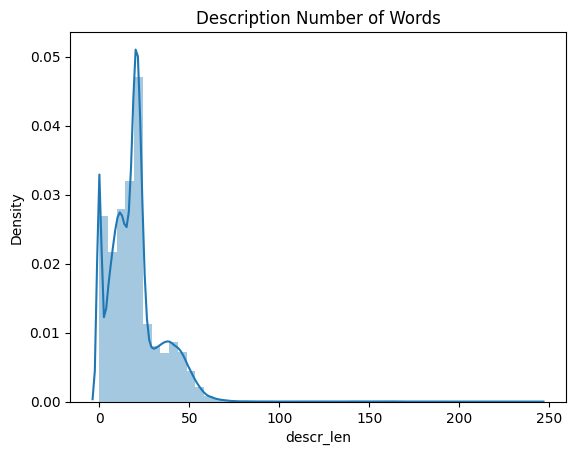

<ipython-input-12-284f9559adce>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['headline_len'])


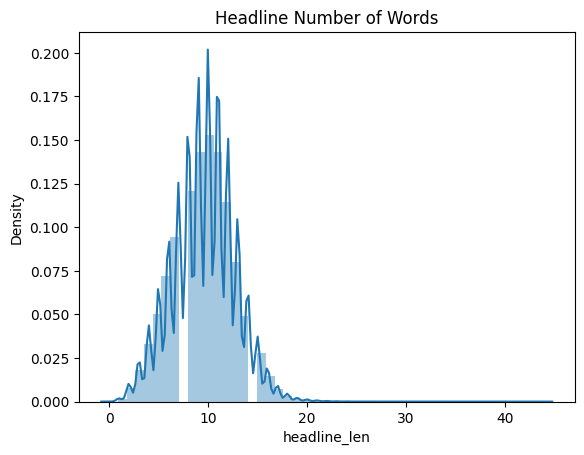

<ipython-input-12-284f9559adce>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['descr_len'])


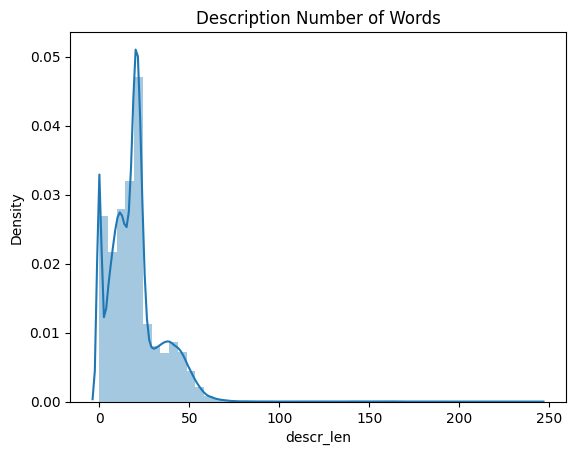

In [12]:
# 畫圖
sns.distplot(df['descr_len'])
plt.title('Description Number of Words')
plt.show()
sns.distplot(df['headline_len'])
plt.title('Headline Number of Words')
plt.show()
sns.distplot(df['descr_len'])
plt.title('Description Number of Words')
plt.show()


In [13]:
# 由此兩圖發現, 有很多資料的description長度為零, 但大多數的資料都有headline
# 因此決定 把description加入headline
df['short_description'] = df['headline'] + df['short_description']

<ipython-input-14-a4c0961bbf43>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['headline_len'] + df['descr_len'])


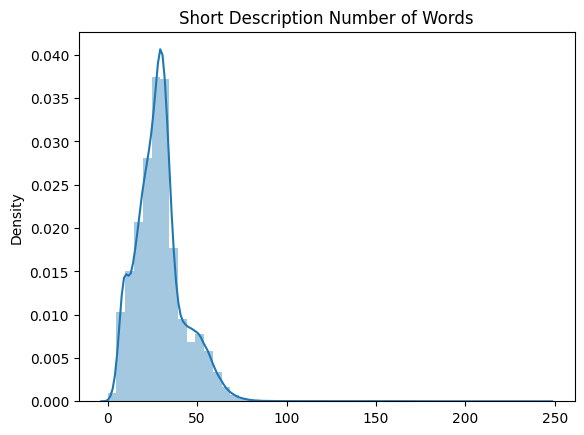

In [14]:
# 再來畫圖看一下headline長度加description長度
sns.distplot(df['headline_len'] + df['descr_len'])
plt.title('Short Description Number of Words')
plt.show()

沒有什麼長度0的欄位了！

# **Tokenizing**

In [15]:
def regular_encode(texts, tokenizer, maxlen = 512):
    enc_di = tokenizer.batch_encode_plus(
        texts,                           # 要來encode的text
        return_attention_mask = False,   # 不返回attention mask
        return_token_type_ids = False,    # 不返回token類型
        pad_to_max_length = True,        # 把編碼結果填充至最大長度(maxlen)
        max_length = maxlen              # 設置最大長度
    )
    # batch_encode_plus 的方法會返回一個字典，其中input_ids是最重要的部分
    # 把結果存為numpy array 回傳
    return np.array(enc_di['input_ids'])

In [16]:
# bert large uncased 有 pretrain tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

此模型的用途是「重新給此資料集新的標籤, 因此我決定將一半的資料拿來訓練模型，測試資料則拿來re-label, 給下個階段的模型做使用, 因此此段程式碼裡面不包含prediction, evaluation.

In [17]:
# 分訓練集和測試集
x_train, x_test, y_train, y_test = train_test_split(df['short_description'], df['categoryEncoded'], random_state = 2024, test_size = 0.5)
# random_state 是確保每次分割結果都相同。

* Tokenizing the description with regular_encode function.
* Converting the categortEncoded to one hot vector with tf.keras.utils.to_categorical function.

In [18]:
xtrain_encoded = regular_encode(x_train.astype('str'), tokenizer, maxlen = 80)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes = 41, dtype = 'int32')

xtest_encoded = regular_encode(x_test.astype('str'), tokenizer, maxlen = 80)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes = 41, dtype = 'int32')


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# 開始建構模型！

In [19]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    # attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    # transformer_output = transformer(input_word_ids)
    sequence_output = transformer(input_word_ids)[0]
    # pooled_output = transformer_output.pooler_output

    cls_token = sequence_output[:, 0, :]
    #adding dropout layer
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    #using a dense layer of 40 neurons as the number of unique categories is 40.
    out = tf.keras.layers.Dense(41, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    #using categorical crossentropy as the loss as it is a multi-class classification problem
    model.compile(tf.keras.optimizers.Adam(learning_rate=3e-5), loss=loss, metrics=['accuracy'])
    return model

In [20]:
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
    model = build_model(transformer_layer, max_len = 80)
model.summary()

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 80)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  335141888
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             80, 1024),                          
                              pooler_output=(None, 10            
                             24),                                
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

# 開始訓練模型！

In [21]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync # 設定batch 大小
AUTO = tf.data.experimental.AUTOTUNE # 自動調整數據管道性能
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((xtrain_encoded, ytrain_encoded))
    .repeat() # 允許無限次迭代
    .shuffle(2048) # 打亂數據
    .batch(BATCH_SIZE) # 把數據分為BATCH_SIZE大小的批次
    .prefetch(AUTO) # 預取資料，訓練的同時可以並行加載資料
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(xtest_encoded)
    .batch(BATCH_SIZE)
)


In [22]:
n_steps = xtrain_encoded.shape[0] // BATCH_SIZE # 計算一個epochs需要幾步完成
train_history = model.fit(
    train_dataset, # 之前定義的訓練數據集，包括重複、隨機打亂、批次和預取操作。
    steps_per_epoch = n_steps,
    epochs = 10 # 迭代10次
)

Epoch 1/10


409/409 [==============================] - 356s 460ms/step - loss: 1.5215 - accuracy: 0.5841
Epoch 2/10
409/409 [==============================] - 188s 460ms/step - loss: 1.0749 - accuracy: 0.6810
Epoch 3/10
409/409 [==============================] - 188s 459ms/step - loss: 0.9022 - accuracy: 0.7255
Epoch 4/10
409/409 [==============================] - 188s 459ms/step - loss: 0.7636 - accuracy: 0.7615
Epoch 5/10
409/409 [==============================] - 188s 459ms/step - loss: 0.6098 - accuracy: 0.8061
Epoch 6/10
409/409 [==============================] - 187s 458ms/step - loss: 0.4888 - accuracy: 0.8427
Epoch 7/10
409/409 [==============================] - 188s 459ms/step - loss: 0.3541 - accuracy: 0.8834
Epoch 8/10
409/409 [==============================] - 187s 458ms/step - loss: 0.2468 - accuracy: 0.9183
Epoch 9/10
409/409 [==============================] - 188s 459ms/step - loss: 0.1908 - accuracy: 0.9369
Epoch 10/10
409/409 [==============================] - 188s 459ms/step - lo

In [25]:
preds = model.predict(test_dataset, verbose = 1)
pred_classes = np.argmax(preds, axis = 1)

410/410 [==============================] - 58s 134ms/step


In [26]:
encoded_classes = encoder.classes_
predicted_category = [encoded_classes[x] for x in pred_classes]
true_category = [encoded_classes[x] for x in y_test]

In [27]:
result_df = pd.DataFrame({'dexcription' : x_test, 'true_category' : true_category, 'predicted_category' : predicted_category})
result_df.head()

,dexcription,true_category,predicted_category
52022,catholics: please do not cite dorothy day as a...,RELIGION,RELIGION
50712,teachers join with southern poverty law center...,POLITICS,POLITICS
19665,new york times defends its inflammatory nazi s...,MEDIA,MEDIA
118748,justice department blocks deportation of immig...,POLITICS,POLITICS
2932,ex-track and field coach allegedly tricks stud...,CRIME,U.S. NEWS


# 來看看此模型的「單標籤分類」的正確性。

In [28]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")

Accuracy is 0.6860467336107823


沒有很高，但沒關係，因為此程式主要是來re-label，所以，再predict train_dataset一次。

In [31]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync # 設定batch 大小
AUTO = tf.data.experimental.AUTOTUNE # 自動調整數據管道性能
re_label_dataset = ( # 在這裡，重新命名為re_label_datase，但內容其實就是train.
    tf.data.Dataset
    .from_tensor_slices(xtrain_encoded)
    .batch(BATCH_SIZE)
)

In [33]:
preds2 = model.predict(re_label_dataset, verbose = 1)

410/410 [==============================] - 55s 129ms/step


In [39]:
pred2_classes = np.argmax(preds2, axis = 1)

In [40]:
encoded_classes = encoder.classes_
predicted_category = [encoded_classes[x] for x in pred2_classes]
true_category = [encoded_classes[x] for x in y_train]

In [41]:
result_df = pd.DataFrame({'dexcription' : x_train, 'true_category' : true_category, 'predicted_category' : predicted_category})
result_df.head()

,dexcription,true_category,predicted_category
163794,how's your sex life?by not sharing your real t...,WELLNESS,WELLNESS
199586,how to keep your child safe (and happy) online...,PARENTING,PARENTING
161264,ground beef recipes that go beyond burgersthin...,FOOD & DRINK,FOOD & DRINK
138053,why there are no winners in the battle of brea...,PARENTING,PARENTING
21001,the duchess of cambridge's black lace dress is...,STYLE,STYLE


In [42]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")

Accuracy is 0.9850042476828651


# 這樣正確率就高了許多！

In [47]:
# 看一下有哪些類別
print(encoded_classes)

['ARTS' 'ARTS & CULTURE' 'BLACK VOICES' 'BUSINESS' 'COLLEGE' 'COMEDY'
 'CRIME' 'CULTURE & ARTS' 'DIVORCE' 'EDUCATION' 'ENTERTAINMENT'
 'ENVIRONMENT' 'FIFTY' 'FOOD & DRINK' 'GOOD NEWS' 'GREEN' 'HEALTHY LIVING'
 'HOME & LIVING' 'IMPACT' 'LATINO VOICES' 'MEDIA' 'MONEY' 'PARENTING'
 'PARENTS' 'POLITICS' 'QUEER VOICES' 'RELIGION' 'SCIENCE' 'SPORTS' 'STYLE'
 'STYLE & BEAUTY' 'TASTE' 'TECH' 'TRAVEL' 'U.S. NEWS' 'WEDDINGS'
 'WEIRD NEWS' 'WELLNESS' 'WOMEN' 'WORLD NEWS' 'WORLDPOST']


In [87]:
# 先來建構一下csv
newColumn = 'description'
columnsName = np.append(newColumn, encoded_classes)

re_label_df = pd.DataFrame(columns=columnsName)
print(re_label_df)

Empty DataFrame
Columns: [description, ARTS, ARTS & CULTURE, BLACK VOICES, BUSINESS, COLLEGE, COMEDY, CRIME, CULTURE & ARTS, DIVORCE, EDUCATION, ENTERTAINMENT, ENVIRONMENT, FIFTY, FOOD & DRINK, GOOD NEWS, GREEN, HEALTHY LIVING, HOME & LIVING, IMPACT, LATINO VOICES, MEDIA, MONEY, PARENTING, PARENTS, POLITICS, QUEER VOICES, RELIGION, SCIENCE, SPORTS, STYLE, STYLE & BEAUTY, TASTE, TECH, TRAVEL, U.S. NEWS, WEDDINGS, WEIRD NEWS, WELLNESS, WOMEN, WORLD NEWS, WORLDPOST]
Index: []

[0 rows x 42 columns]


In [92]:
threshold = 0.0001
pred_re_label_classes = [np.where(sample > threshold)[0] for sample in preds2]
predicted_category = []
for _ in pred_re_label_classes:
    predicted_category.append([encoded_classes[x] for x in _])
#print(predicted_category)
count = sum(1 for sublist in predicted_category if len(sublist) > 1)
print(f'當threshold = {threshold}時, 多標籤的比例為{count / len(predicted_category)}')


當threshold = 0.0001時, 多標籤的比例為0.7087903171921385


# 可以開始進行re-label了！

In [95]:
re_label_df = pd.DataFrame({'description':x_train, 'predicted_category':predicted_category})
re_label_df.head()
# pd.set_option('display.max_rows', 20)
# print(re_label_df)
re_label_df.to_csv('/content/drive/My Drive/AI-Final-Project/re_label_dataset.csv', index = False)